In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [3]:
proj_name = "ranking_integration_methods"

file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

# load the pickle files

In [6]:
import pickle as pkl

In [120]:
# cross_tissue_Eraslan
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16")
    / "benchmark_cell_type_summary_old"
    / "benchmark_cross_tissue_Eraslan_Jul16-1656.pkl"
)

with open(file_path, "rb") as f:
    bm_cross_tissue_Eraslan = pkl.load(f)


In [25]:
# HypoMap_Steuernagel
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16")
    / "benchmark_cell_type_summary"
    / "benchmark_HypoMap_Steuernagel_refined_Jul18-0919.pkl"
)
with open(file_path, "rb") as f:
    bm_HypoMap_Steuernagel = pkl.load(f)

In [17]:
# immune_DominguezConde
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16")
    / "benchmark_cell_type_summary"
    / "benchmark_immune_DominguezConde_Jul16-1121.pkl"
)
with open(file_path, "rb") as f:
    bm_immune_DominguezConde = pkl.load(f)

In [18]:
# pancreatic_islet_Hrovatin
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16")
    / "benchmark_cell_type_summary"
    / "benchmark_pancreatic_islet_Hrovatin_Jul16-1347.pkl"
)
with open(file_path, "rb") as f:
    bm_pancreatic_islet_Hrovatin = pkl.load(f)

In [19]:
# TabulaSapiens
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul16")
    / "benchmark_cell_type_summary"
    / "benchmark_TabulaSapiens_Jul18-1606.pkl"
)
with open(file_path, "rb") as f:
    bm_TabulaSapiens = pkl.load(f)

----

# update the combined score

In [40]:
import pandas as pd
import pickle
from pathlib import Path

def update_combined_aggregate_scores(pickle_path: str | Path, output_path: str | Path = None):
    """
    Load a nested benchmark dictionary from a pickle file, update the
    'Aggregate score' fields in the 'combined' DataFrame, and save the result.

    Parameters
    ----------
    pickle_path : str or Path
        Path to the input pickle file.
    output_path : str or Path, optional
        Path to save the updated pickle. If not provided, appends '_updated' to the input filename.
    """
    pickle_path = Path(pickle_path)
    if output_path is None:
        output_path = pickle_path.with_stem(pickle_path.stem + "_updated")
    
    # Load
    with open(pickle_path, "rb") as f:
        bm = pickle.load(f)

    df = bm["combined"]

    # Recompute scores
    df.loc[:, ("Aggregate score", "Batch correction")] = df["Batch correction"].mean(axis=1)
    df.loc[:, ("Aggregate score", "Bio conservation")] = df["Bio conservation"].mean(axis=1)

    # Average the two sub-aggregate scores directly
    total_score = df.loc[:, ("Aggregate score", "Batch correction")].astype(float).add(
        df.loc[:, ("Aggregate score", "Bio conservation")].astype(float)
    ).div(2)

    df.loc[:, ("Aggregate score", "Total")] = total_score

    # Drop the old "Aggregate score", "Average" column
    if ("Aggregate score", "Average") in df.columns:
        df.drop(columns=[("Aggregate score", "Average")], inplace=True) 

    # Save to new file
    with open(output_path, "wb") as f:
        pickle.dump(bm, f)

    print(f"Updated file saved to: {output_path}")


In [51]:
file_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_old"
    / "benchmark_TabulaSapiens_n=300_Jul23-2142.pkl"
)

output_path = (
    Path("/Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24")
    / "benchmark_cell_type_summary_updated"
    / f"benchmark_TabulaSapiens_n=300_{file_suffix}.pkl"
)

In [52]:
update_combined_aggregate_scores(file_path, output_path)

Updated file saved to: /Volumes/Shared/Concord_backup/save/results_concord-1.0.6_adjusted_metrics_Jul24/benchmark_cell_type_summary_updated/benchmark_TabulaSapiens_n=300_Jul24-1358.pkl


----

# plot the ranking results of the integration methods

In [54]:
def plot_ranked_scores(
    score_dict: dict[str, pd.Series],
    figsize=(3, 0.5),
    custom_rc=None,
    method_order: list[str] | None = None,
    save_dir: Path | None = None,
    title: str = "Method Rankings",
    file_name: str = "ranked_scores_heatmap",
    save_format: str = "pdf",
):
    """
    Plots a heatmap of method rankings across datasets and optionally saves the plot.

    Parameters
    ----------
    score_dict : dict
        Keys are desired dataset names; values are Series of scores with method names as index.

    figsize : tuple
        Size of the heatmap (width, height).

    custom_rc : dict
        Optional matplotlib rcParams override (e.g., font settings).

    save_dir : Path or None
        If specified, saves the plot as a PDF in this directory.

    file_name : str
        Name of the saved file (default = 'ranked_scores_heatmap.pdf').
    """
    # Combine scores
    all_scores = pd.concat(score_dict.values(), axis=1)
    all_scores.columns = list(score_dict.keys())

    # Compute rank
    ranked = all_scores.rank(axis=0, ascending=False).astype("Int64")
    heatmap_data = ranked.astype(float)

    # Annotation
    annot_text = heatmap_data.applymap(lambda val: str(int(val)) if pd.notna(val) else "-")

    # Reorder methods if specified
    if method_order is not None:
        valid_methods = [m for m in method_order if m in heatmap_data.index]
        heatmap_data = heatmap_data.reindex(valid_methods)
        annot_text = annot_text.reindex(index=valid_methods)

    # Colormap
    cmap = sns.color_palette("viridis_r", as_cmap=True)
    cmap.set_bad(color="lightgrey")

    # Plot
    with plt.rc_context(rc=custom_rc or {}):
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            heatmap_data.T,
            annot=annot_text.T,
            fmt="",
            cmap=cmap,
            linewidths=1,
            linecolor="white",
            cbar=False
        )

        # Set title
        ax.set_title(title, fontsize=12, pad=10)
        plt.tight_layout()
        
        # Optional save
        if save_dir is not None:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)
            file_path = save_dir / f"{file_name}.{save_format}"
            plt.savefig(file_path, format=save_format)

        plt.show()

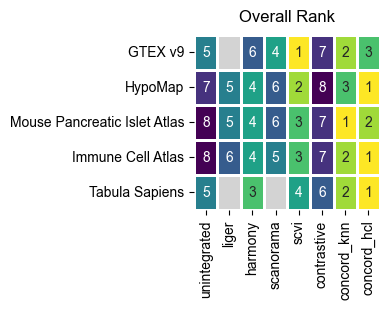

In [58]:
score_dict = {
    "GTEX v9": bm_cross_tissue_Eraslan["combined"]["Aggregate score"]["Average"],
    "HypoMap": bm_HypoMap_Steuernagel["combined"]["Aggregate score"]["Average"],
    "Mouse Pancreatic Islet Atlas": bm_pancreatic_islet_Hrovatin["combined"]["Aggregate score"]["Average"],
    "Immune Cell Atlas": bm_immune_DominguezConde["combined"]["Aggregate score"]["Average"],
    "Tabula Sapiens": bm_TabulaSapiens["combined"]["Aggregate score"]["Average"]
}

method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

title = "Overall Rank"

plot_ranked_scores(score_dict,
                   figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                   custom_rc=custom_rc,
                   method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_scores_heatmap_{title}_{file_suffix}",
                    save_format="svg"
                   )

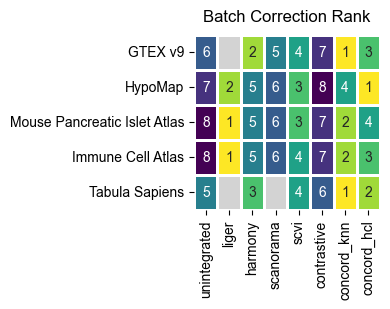

In [61]:
score_dict = {
    "GTEX v9": bm_cross_tissue_Eraslan["combined"]["Aggregate score"]["Batch correction"],
    "HypoMap": bm_HypoMap_Steuernagel["combined"]["Aggregate score"]["Batch correction"],
    "Mouse Pancreatic Islet Atlas": bm_pancreatic_islet_Hrovatin["combined"]["Aggregate score"]["Batch correction"],
    "Immune Cell Atlas": bm_immune_DominguezConde["combined"]["Aggregate score"]["Batch correction"],
    "Tabula Sapiens": bm_TabulaSapiens["combined"]["Aggregate score"]["Batch correction"]
}

method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

title = "Batch Correction Rank"

plot_ranked_scores(score_dict,
                   figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                   custom_rc=custom_rc,
                   method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_scores_heatmap_{title}_{file_suffix}",
                    save_format="pdf"
                   )

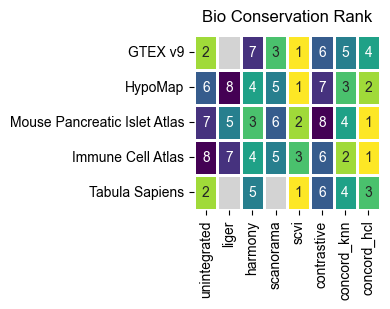

In [63]:
score_dict = {
    "GTEX v9": bm_cross_tissue_Eraslan["combined"]["Aggregate score"]["Bio conservation"],
    "HypoMap": bm_HypoMap_Steuernagel["combined"]["Aggregate score"]["Bio conservation"],
    "Mouse Pancreatic Islet Atlas": bm_pancreatic_islet_Hrovatin["combined"]["Aggregate score"]["Bio conservation"],
    "Immune Cell Atlas": bm_immune_DominguezConde["combined"]["Aggregate score"]["Bio conservation"],
    "Tabula Sapiens": bm_TabulaSapiens["combined"]["Aggregate score"]["Bio conservation"]
}

method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

title = "Bio Conservation Rank"

plot_ranked_scores(score_dict,
                   figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                   custom_rc=custom_rc,
                   method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_scores_heatmap_{title}_{file_suffix}",
                    save_format="svg"
                   )